In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision
import os
import matplotlib.pyplot as plt
import torchvision.models as models
device = torch.device('cpu')

In [2]:
import torch.nn.functional as F
import math

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def betas_cos(n_steps,max_beta=0.999):
        # 余弦加噪方案生成Beta
        betas = []
        alpha_bar = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
        for i in range(n_steps):
            t1 = i / n_steps
            t2 = (i + 1) / n_steps
            betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
        return torch.Tensor(betas)



# 取得vals中下标为t的数据，并且将其变为符合格式的shape
def get_index_from_list(vals, t, x_shape):
    """ 
    返回所传递的值列表vals中的特定索引，同时考虑到批处理维度。
    """

    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())

    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device=device):
    """ 
    接收一个图像和一个时间步长作为输入，并 返回它的噪声版本
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    #均值+方差
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# 界定测试时间表
T = 1000
beta = betas_cos(T)

In [3]:
# 预先计算闭合形式的不同项
alphas = 1. - beta
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = beta * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

eta = 0

def get_sigma(eta):
    sigma = (
        
            eta
            * torch.sqrt((1 - alphas_cumprod_prev) / (1 - alphas_cumprod))
            * torch.sqrt(1 - alphas_cumprod / alphas_cumprod_prev)
        )
    # print(len(sigma))
    return sigma.to(t.device)

In [4]:
#tensor转化成图像
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image.cpu()))

In [5]:
transform = transforms.Compose([
    # transforms.Resize((256,256)),
    transforms.ToTensor()
])


In [6]:

T = 1000
# beta = linear_beta_schedule(T)
beta = betas_cos(T)
# 预先计算闭合形式的不同项
alphas = 1. - beta
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = beta * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [7]:
to_pil = transforms.ToPILImage()

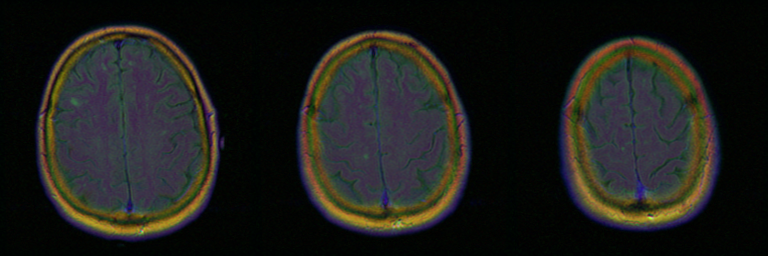

In [8]:
health = transform(Image.open("TCGA_CS_4941_19960909_19.tif"))
to_pil(health)

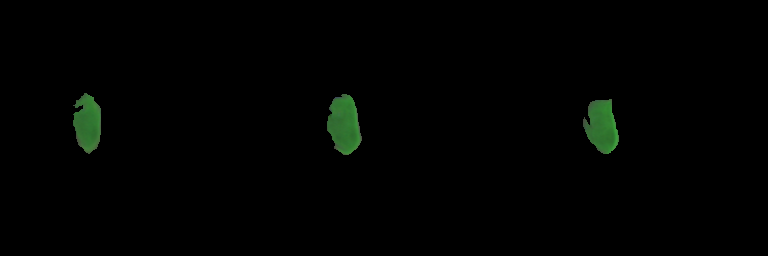

In [9]:
tumor = transform(Image.open("TCGA_CS_4942_19970222_11.tif"))
to_pil(tumor)

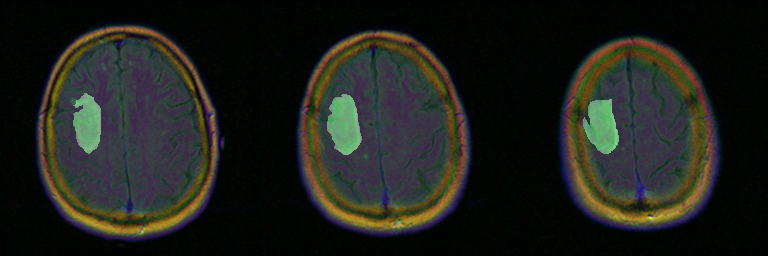

In [10]:
img = health+tumor
to_pil(img)

In [11]:
left_img,middle_img,right_img = torch.chunk(img,3,2)
res, noise = forward_diffusion_sample(middle_img torch.tensor([100]))
res_img = torch.cat([left_img,res,right_img],2)
res_img = to_pil(res_img)
res_img

SyntaxError: invalid syntax (2294476840.py, line 2)